Refer: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import random
import os
import glob
import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

%matplotlib inline
# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [166]:
data = pd.read_csv("visual_spark_final.csv")

In [167]:
data.head()

,date_time,date,day,uber_display_name,uber_distance,uber_duration,end_latitude,end_location,end_longitude,uber_max_estimate,...,lyft_distance,lyft_duration,lyft_max_estimate_per_mile,lyft_min_estimate_per_mile,uber_max_estimate_per_mile,uber_min_estimate_per_mile,uber_max_estimate_per_sec,uber_min_estimate_per_sec,lyft_max_estimate_per_sec,lyft_min_estimate_per_sec
0,2/25/18 0:00,25-Feb-18,Sunday,POOL,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,13,...,3.1,745,6.712903,6.712903,4.593640,3.180212,0.024074,0.016667,0.027933,0.027933
1,2/25/18 0:00,25-Feb-18,Sunday,uberX,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,12,...,3.1,745,1.135484,1.135484,4.240283,3.180212,0.022222,0.016667,0.004725,0.004725
2,2/25/18 0:00,25-Feb-18,Sunday,uberSUV,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,35,...,3.1,745,8.738710,8.738710,12.367491,9.893993,0.064815,0.051852,0.036362,0.036362
3,2/25/18 0:00,25-Feb-18,Sunday,uberXL,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,20,...,3.1,745,3.335484,3.335484,7.067138,5.300353,0.037037,0.027778,0.013879,0.013879
4,2/25/18 0:00,25-Feb-18,Sunday,UberBLACK,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,25,...,3.1,745,5.777419,5.777419,8.833922,6.713781,0.046296,0.035185,0.024040,0.024040


In [168]:
data.columns

Index(['date_time', 'date', 'day', 'uber_display_name', 'uber_distance',
       'uber_duration', 'end_latitude', 'end_location', 'end_longitude',
       'uber_max_estimate', 'uber_min_estimate', 'main_temp', 'main_temp_max',
       'main_temp_min', 'uber_product_id', 'start_latitude', 'start_location',
       'start_longitude', 'time', 'weather', 'lyft_display_name',
       'lyft_max_estimate', 'lyft_min_estimate', 'lyft_distance',
       'lyft_duration', 'lyft_max_estimate_per_mile',
       'lyft_min_estimate_per_mile', 'uber_max_estimate_per_mile',
       'uber_min_estimate_per_mile', 'uber_max_estimate_per_sec',
       'uber_min_estimate_per_sec', 'lyft_max_estimate_per_sec',
       'lyft_min_estimate_per_sec'],
      dtype='object')

In [169]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [170]:
data.index

DatetimeIndex(['2018-02-25 00:00:00', '2018-02-25 00:00:00',
               '2018-02-25 00:00:00', '2018-02-25 00:00:00',
               '2018-02-25 00:00:00', '2018-02-25 00:00:00',
               '2018-02-25 00:01:00', '2018-02-25 00:01:00',
               '2018-02-25 00:01:00', '2018-02-25 00:01:00',
               ...
               '2018-03-03 23:57:00', '2018-03-03 23:57:00',
               '2018-03-03 23:57:00', '2018-03-03 23:57:00',
               '2018-03-03 23:58:00', '2018-03-03 23:58:00',
               '2018-03-03 23:58:00', '2018-03-03 23:58:00',
               '2018-03-03 23:58:00', '2018-03-03 23:58:00'],
              dtype='datetime64[ns]', name='date_time', length=59880, freq=None)

In [171]:
y_uber_pool=data[data.uber_display_name=='POOL']

In [172]:
y_uber=y_uber_pool['uber_max_estimate_per_mile'].resample('T').mean()

In [173]:
y_uber_h=y_uber_pool['uber_max_estimate_per_mile'].resample('H').mean()

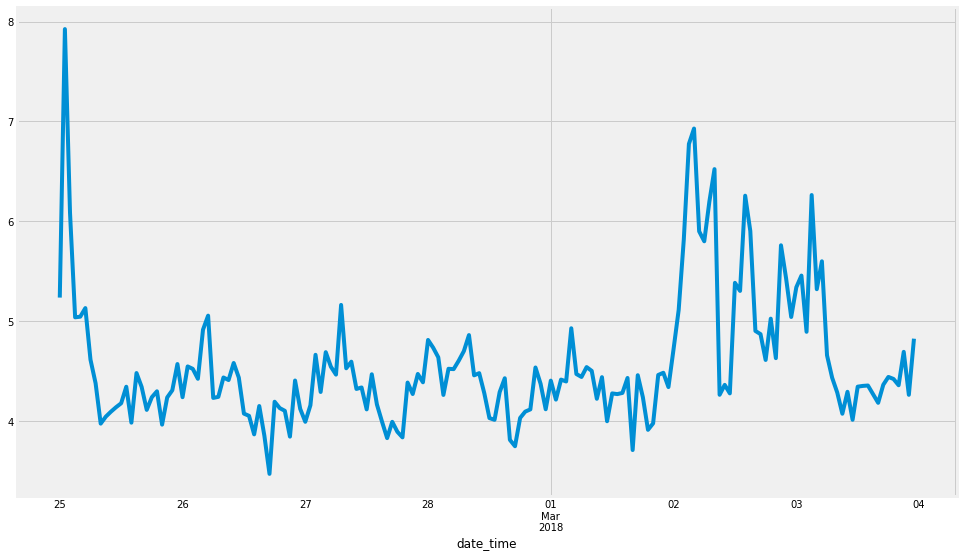

In [174]:
y_uber_h.plot()

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

### check stationary
Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time,

the series to be stationary if it has constant statistical properties over time, ie. the following:

constant mean
<br>
constant variance
<br>
an autocovariance that does not depend on time.

In [175]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

First and foremost is to simple plot the data and analyze visually.

More formally, we can check stationarity using the following:

#### Plotting Rolling Statistics: 
We can plot the moving average or moving variance and see if it varies with time. But again this is more of a visual technique.

#### Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

Plot standard deviation instead of variance to keep the unit similar to mean.

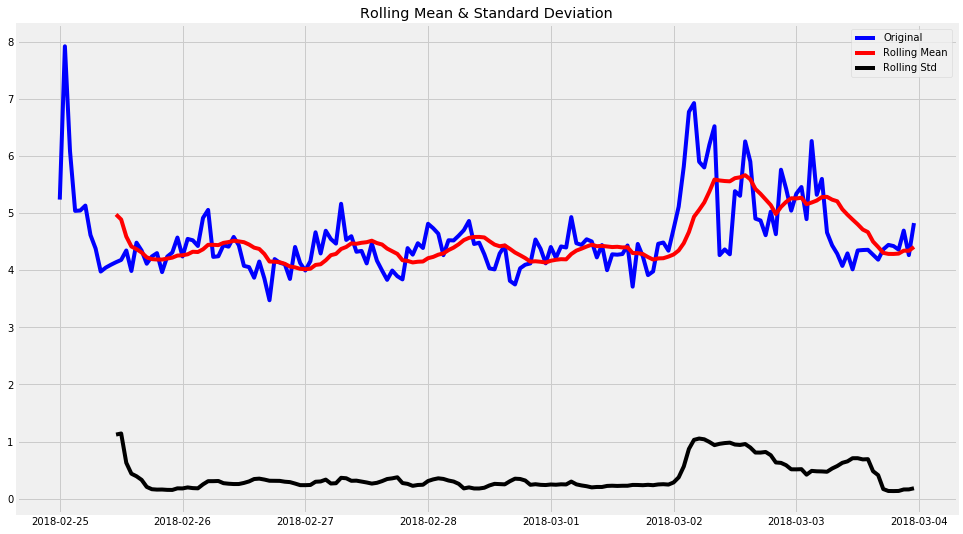

Results of Dickey-Fuller Test:
Test Statistic                  -5.523303
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [176]:
test_stationarity(y_uber_h)

There are 2 major reasons behind non-stationaruty of a TS:
#### 1. Trend  
varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
#### 2. Seasonality 
variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

We can apply <b> transformation </b>  which penalize higher values more than smaller values. 

These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

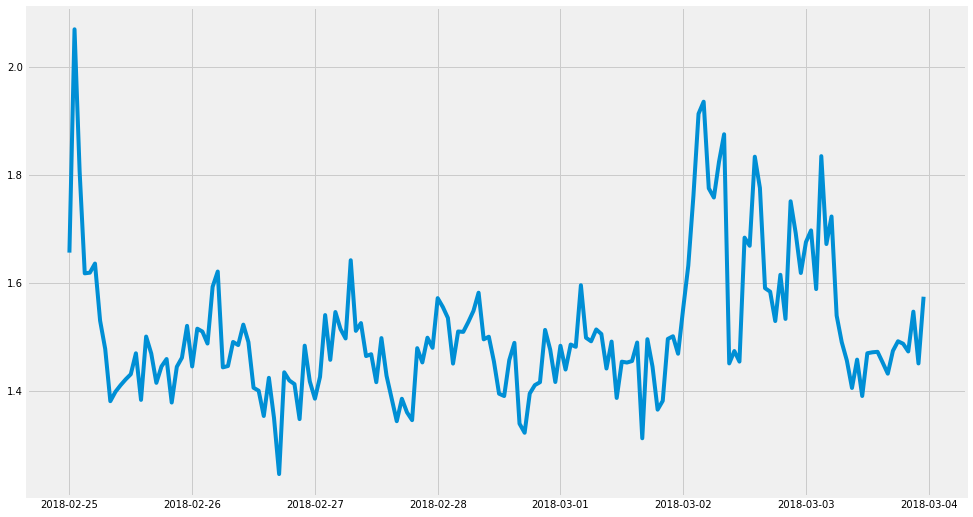

In [177]:
uber_log = np.log(y_uber_h)
plt.plot(uber_log)

It is not very intuitive in presence of noise. 
So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

#### Aggregation 
taking average for a time period like monthly/weekly averages
#### Smoothing 
taking rolling averages
#### Polynomial Fitting 
fit a regression model

### Moving Average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. 

Here we can take the average over the past 1 day, i.e. last 24 values.
pandas has specific functions defined for determining rolling statistics.

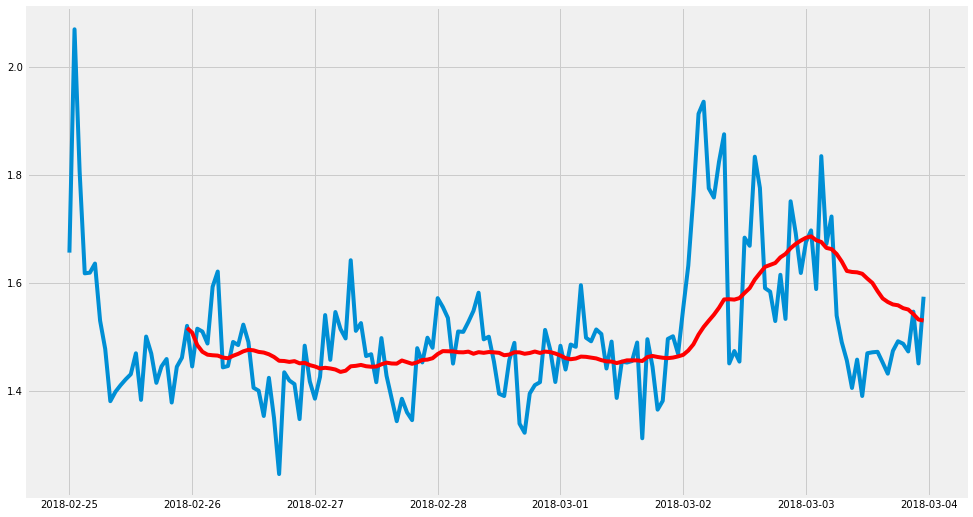

In [178]:
moving_avg = pd.rolling_mean(uber_log,24)
plt.plot(uber_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series.

Lets subtract this from the original series. 

In [179]:
uber_log_moving_avg_diff = uber_log - moving_avg
uber_log_moving_avg_diff.head(24)

date_time
2018-02-25 00:00:00         NaN
2018-02-25 01:00:00         NaN
2018-02-25 02:00:00         NaN
2018-02-25 03:00:00         NaN
2018-02-25 04:00:00         NaN
2018-02-25 05:00:00         NaN
2018-02-25 06:00:00         NaN
2018-02-25 07:00:00         NaN
2018-02-25 08:00:00         NaN
2018-02-25 09:00:00         NaN
2018-02-25 10:00:00         NaN
2018-02-25 11:00:00         NaN
2018-02-25 12:00:00         NaN
2018-02-25 13:00:00         NaN
2018-02-25 14:00:00         NaN
2018-02-25 15:00:00         NaN
2018-02-25 16:00:00         NaN
2018-02-25 17:00:00         NaN
2018-02-25 18:00:00         NaN
2018-02-25 19:00:00         NaN
2018-02-25 20:00:00         NaN
2018-02-25 21:00:00         NaN
2018-02-25 22:00:00         NaN
2018-02-25 23:00:00    0.003734
Freq: H, Name: uber_max_estimate_per_mile, dtype: float64

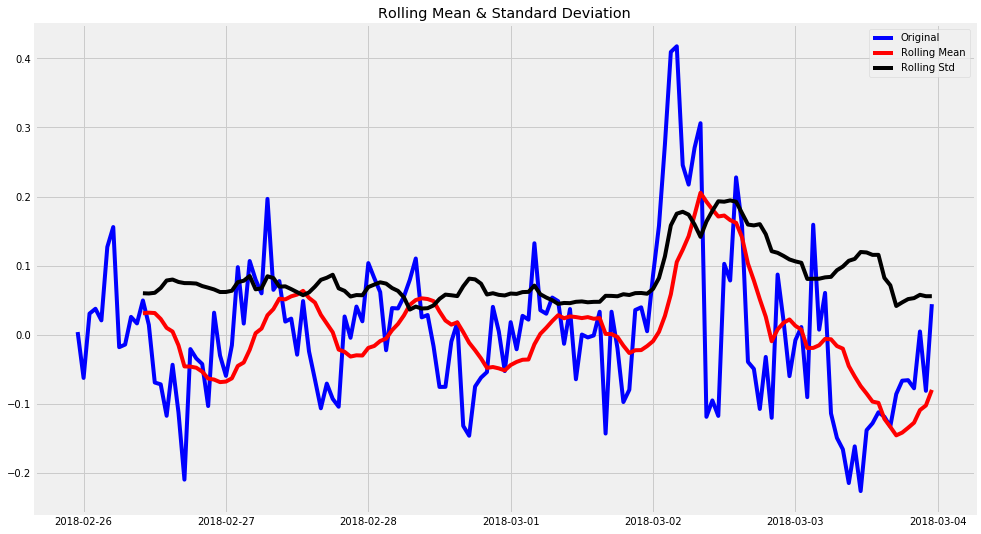

Results of Dickey-Fuller Test:
Test Statistic                  -4.064727
p-value                          0.001107
#Lags Used                       1.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [180]:
uber_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(uber_log_moving_avg_diff)

Rolling Mean and Rolling std change a lot after March 02

Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

### Weighted Moving Average

we take a <b>‘weighted moving average’</b> where more recent values are given a higher weight. 

There can be many technique for assigning weights. 

A popular one is exponentially <b>weighted moving average </b> where weights are assigned to all the previous values with a decay factor. 

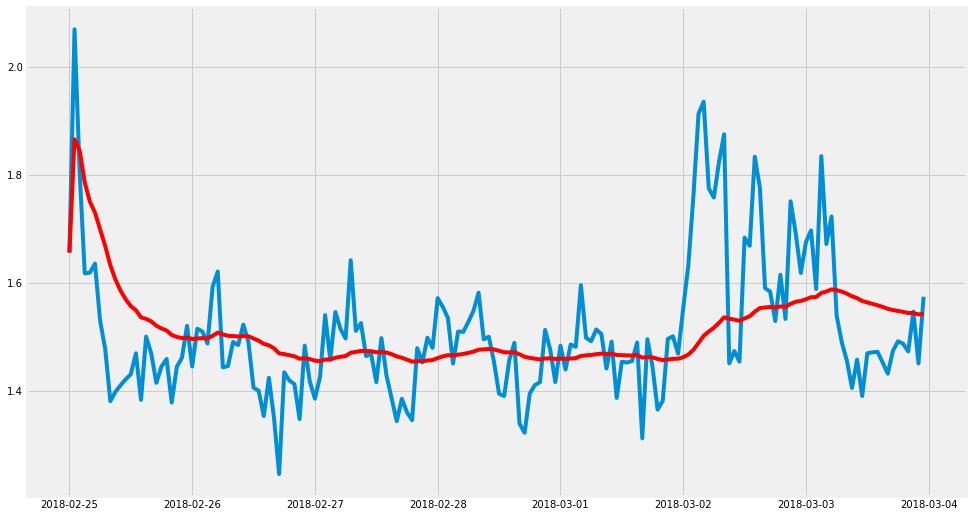

In [181]:
expwighted_avg = pd.ewma(uber_log, halflife=24)
plt.plot(uber_log)
plt.plot(expwighted_avg, color='red')

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay.

This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. 

Now, let’s remove this from series and check stationarity:

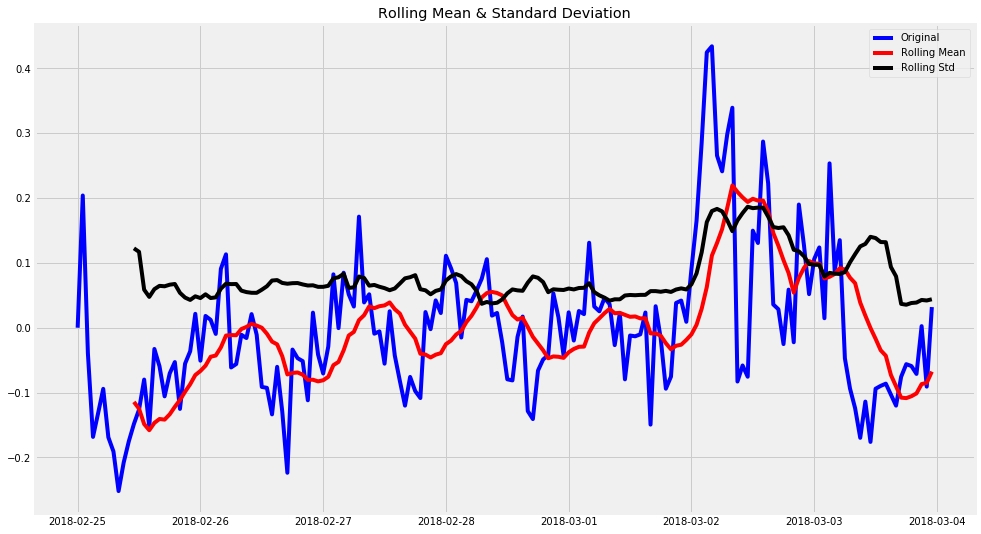

Results of Dickey-Fuller Test:
Test Statistic                  -4.156023
p-value                          0.000781
#Lags Used                       1.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [182]:
uber_log_ewma_diff = uber_log - expwighted_avg
test_stationarity(uber_log_ewma_diff)

Also, the test statistic is 0.000781 which is smaller than the 0.001107 critical value, which is better than the previous case. 

### Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, 
particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

#### 1.Differencing 
taking the differece with a particular time lag
#### 2.Decomposition 
modeling both trend and seasonality and removing them from the model.

### Differencing

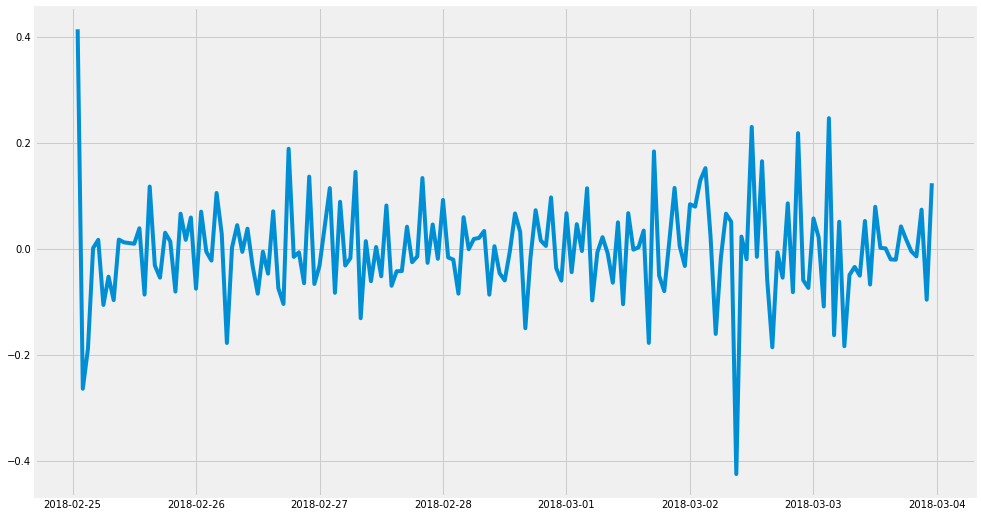

In [183]:
uber_log_diff = uber_log - uber_log.shift()
plt.plot(uber_log_diff)

This appears to have reduced trend considerably. Lets verify using our plots:

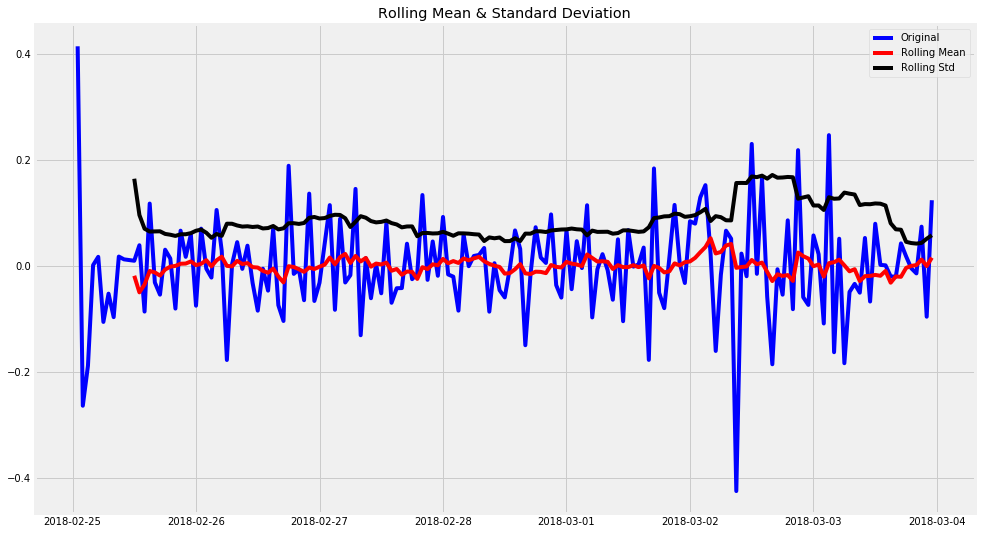

Results of Dickey-Fuller Test:
Test Statistic                  -5.370431
p-value                          0.000004
#Lags Used                      11.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


In [184]:
uber_log_diff.dropna(inplace=True)
test_stationarity(uber_log_diff)

The Dickey-Fuller test statistic is less than the 5% critical value, 
thus the TS is stationary with 95% confidence. 

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. 

### Decomposing

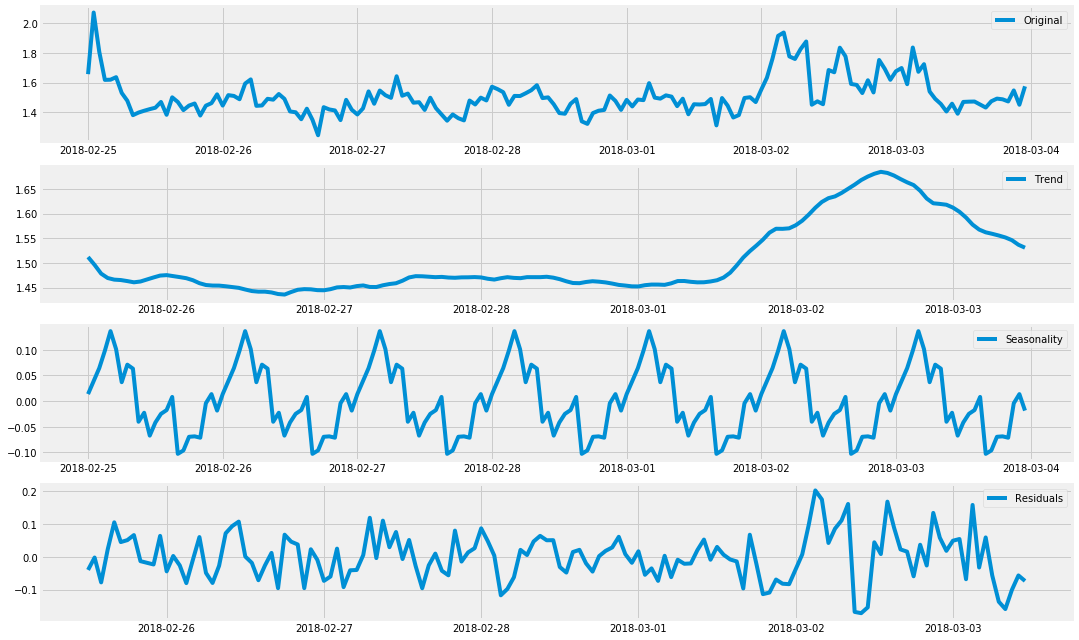

In [185]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(uber_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(uber_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

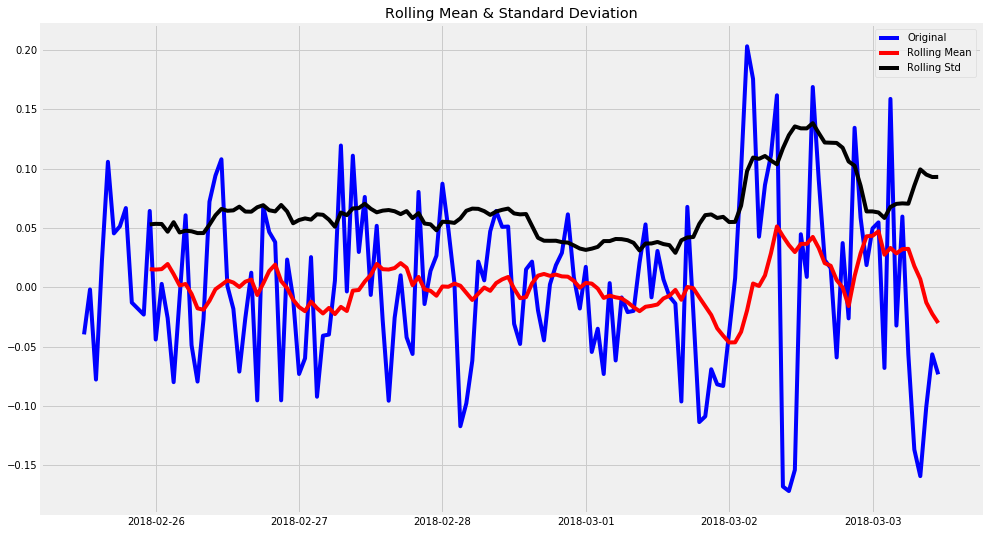

Results of Dickey-Fuller Test:
Test Statistic                -6.478508e+00
p-value                        1.312754e-08
#Lags Used                     2.000000e+00
Number of Observations Used    1.410000e+02
Critical Value (1%)           -3.477601e+00
Critical Value (5%)           -2.882266e+00
Critical Value (10%)          -2.577822e+00
dtype: float64


In [186]:
uber_log_decompose = residual
uber_log_decompose.dropna(inplace=True)
test_stationarity(uber_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. 

## Forecasting a Time Series

Having performed the trend and seasonality estimation techniques, there can be two situations:

#### A strictly stationary series with no dependence among the values. 
This is the easy case wherein we can model the residuals as white noise. But this is very rare.
#### A series with significant dependence among values.
In this case we need to use some statistical models like ARIMA to forecast the data.

### MA Model

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

#### Number of AR (Auto-Regressive) terms (p): 
AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 
MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

#### Number of Differences (d): 
These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


### An importance concern here is how to determine the value of ‘p’ and ‘q’. 
We use two plots to determine these numbers. Lets discuss them first.

#### Autocorrelation Function (ACF): 
It is a measure of the correlation between the the TS with a lagged version of itself. 

For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

#### Partial Autocorrelation Function (PACF): 
This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. 

Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [187]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [188]:
lag_acf = acf(uber_log_diff, nlags=20)
lag_pacf = pacf(uber_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

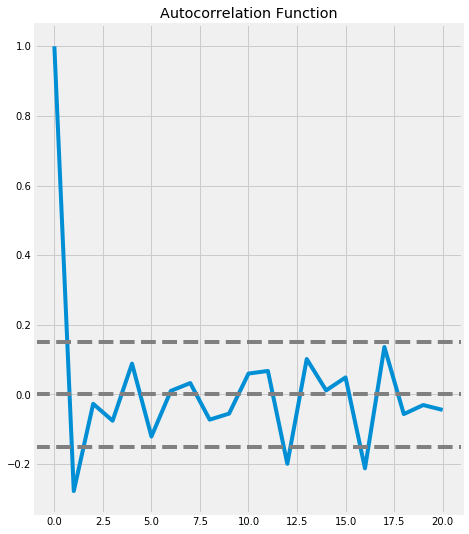

In [189]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(uber_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(uber_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

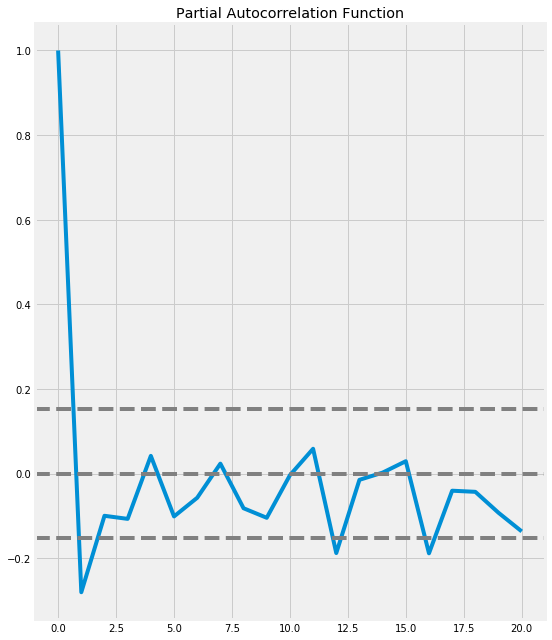

In [190]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(uber_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(uber_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals.
These can be used to determine the ‘p’ and ‘q’ values as:

#### p 
The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
#### q
The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.


Now, lets make 3 different ARIMA models considering individual as well as combined effects. 
I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

In [191]:
from statsmodels.tsa.arima_model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). 
Let model the 3 cases:

Text(0.5,1,'RSS: 1.3753')

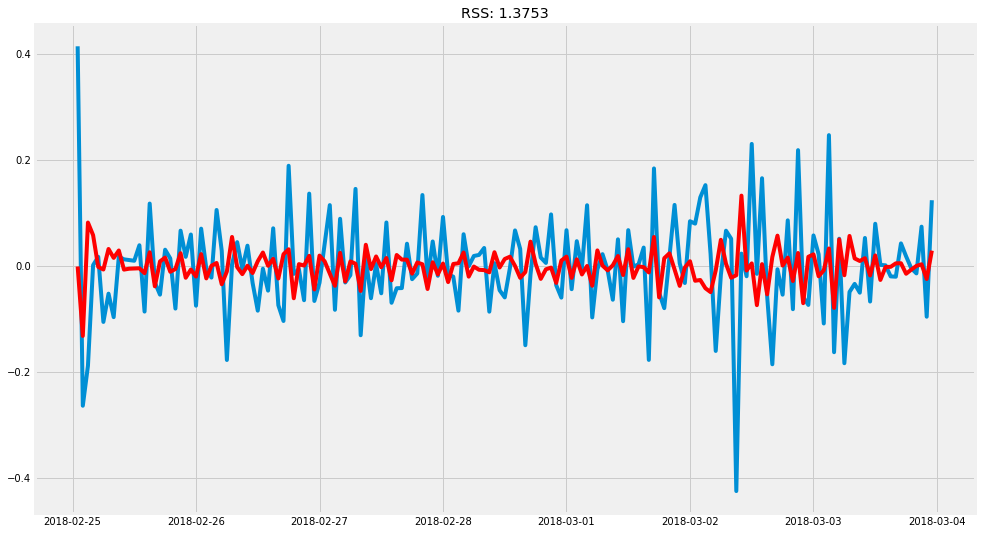

In [192]:
model = ARIMA(uber_log, order=(1, 1, 0))  
results_MA = model.fit(disp=-1)  
plt.plot(uber_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-uber_log_diff)**2))

### AR Model

Text(0.5,1,'RSS: 1.3544')

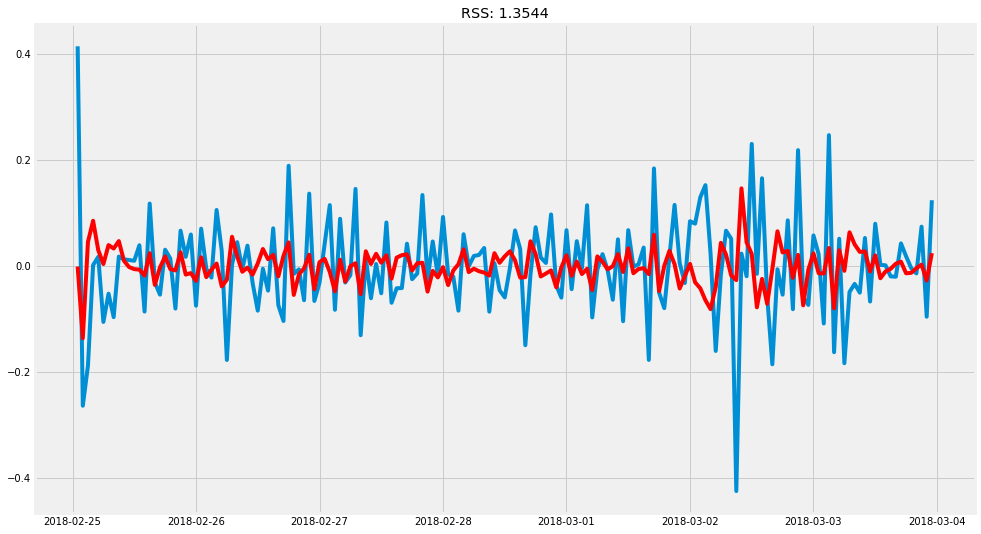

In [193]:
model = ARIMA(uber_log, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(uber_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-uber_log_diff)**2))

### Combined Model

Text(0.5,1,'RSS: 1.3323')

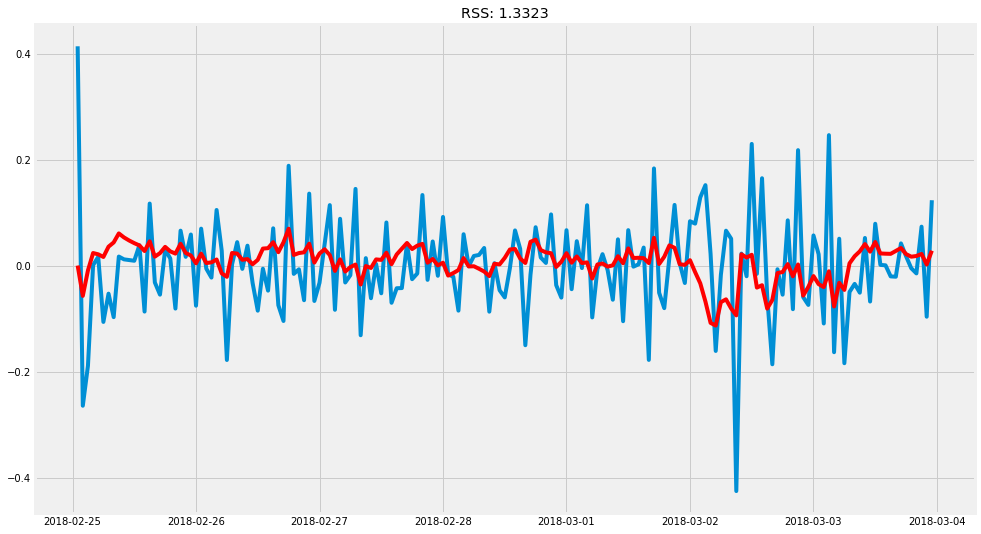

In [194]:
model = ARIMA(uber_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(uber_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-uber_log_diff)**2))

here RSS is for the values of residuals and not actual series.

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 

### Taking it back to original scale

Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. 

First step would be to store the predicted results as a separate series and observe it.

In [195]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date_time
2018-02-25 01:00:00    0.000501
2018-02-25 02:00:00   -0.056678
2018-02-25 03:00:00   -0.008724
2018-02-25 04:00:00    0.024076
2018-02-25 05:00:00    0.021640
Freq: H, dtype: float64


Notice that these start from ‘2018-02-25 01:00:00’ and not the first hour. Why? 

-- This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. 

The way to convert the differencing to log scale is to add these differences consecutively to the base number. 

An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [196]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date_time
2018-02-25 01:00:00    0.000501
2018-02-25 02:00:00   -0.056177
2018-02-25 03:00:00   -0.064901
2018-02-25 04:00:00   -0.040825
2018-02-25 05:00:00   -0.019185
Freq: H, dtype: float64


You can quickly do some back of mind calculations using previous output to check if these are correct. 

Next we’ve to add them to base number. 

For this lets create a series with all values as base number and add the differences to it. 

This can be done as:

In [197]:
predictions_ARIMA_log = pd.Series(uber_log.ix[0], index=uber_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date_time
2018-02-25 00:00:00    1.656027
2018-02-25 01:00:00    1.656528
2018-02-25 02:00:00    1.599850
2018-02-25 03:00:00    1.591126
2018-02-25 04:00:00    1.615202
Freq: H, dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. 

Last step is to take the exponent and compare with the original series.

Text(0.5,1,'RMSE: 14.9409')

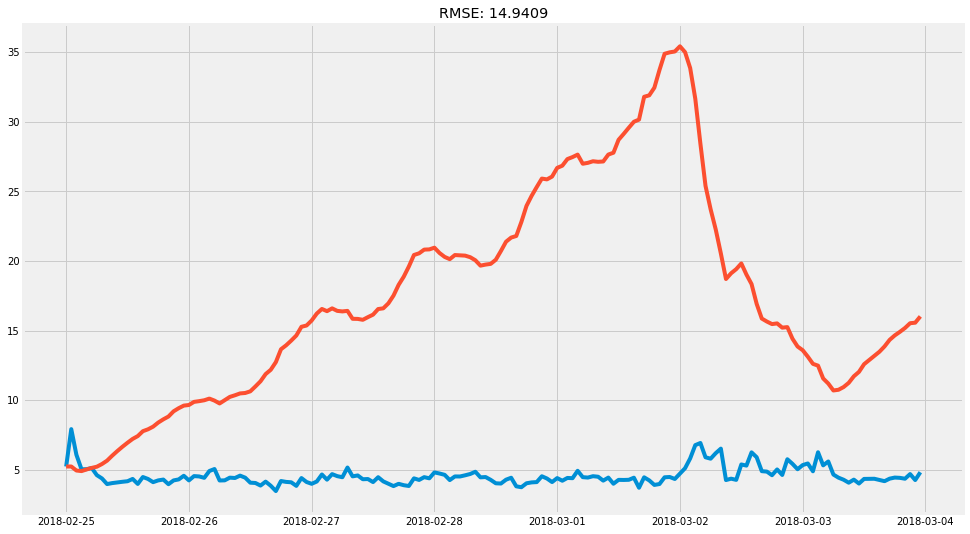

In [198]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(y_uber_h)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-y_uber_h)**2)/len(y_uber_h)))

https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima

#### 3. Plot the ACF and PACF charts and find the optimal parameters
The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs.

Below are the ACF and PACF charts for the seasonal first difference values 

In [216]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    plt.xlabel('Time in Years', fontsize = 20)
    plt.ylabel('Total Emissions', fontsize = 20)
    plt.legend(loc='best', fontsize = 20)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block= True)

In [225]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [232]:
TestStationaryAdfuller(y_uber_h)

Test Statistic                  -5.523303
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


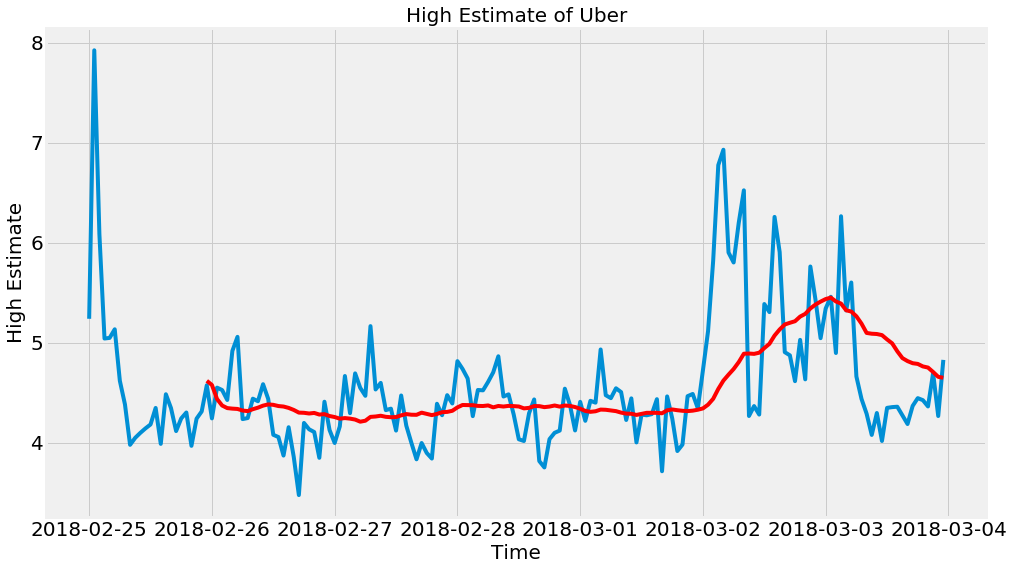

In [217]:
#moving average
moving_avg = y_uber_h.rolling(24).mean()
plt.plot(y_uber_h)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('High Estimate', fontsize = 20)
plt.title('High Estimate of Uber', fontsize = 20)
plt.show()

In [218]:
uber_moving_avg_diff = y_uber_h - moving_avg
uber_moving_avg_diff.head(24)

date_time
2018-02-25 00:00:00         NaN
2018-02-25 01:00:00         NaN
2018-02-25 02:00:00         NaN
2018-02-25 03:00:00         NaN
2018-02-25 04:00:00         NaN
2018-02-25 05:00:00         NaN
2018-02-25 06:00:00         NaN
2018-02-25 07:00:00         NaN
2018-02-25 08:00:00         NaN
2018-02-25 09:00:00         NaN
2018-02-25 10:00:00         NaN
2018-02-25 11:00:00         NaN
2018-02-25 12:00:00         NaN
2018-02-25 13:00:00         NaN
2018-02-25 14:00:00         NaN
2018-02-25 15:00:00         NaN
2018-02-25 16:00:00         NaN
2018-02-25 17:00:00         NaN
2018-02-25 18:00:00         NaN
2018-02-25 19:00:00         NaN
2018-02-25 20:00:00         NaN
2018-02-25 21:00:00         NaN
2018-02-25 22:00:00         NaN
2018-02-25 23:00:00   -0.044344
Freq: H, Name: uber_max_estimate_per_mile, dtype: float64

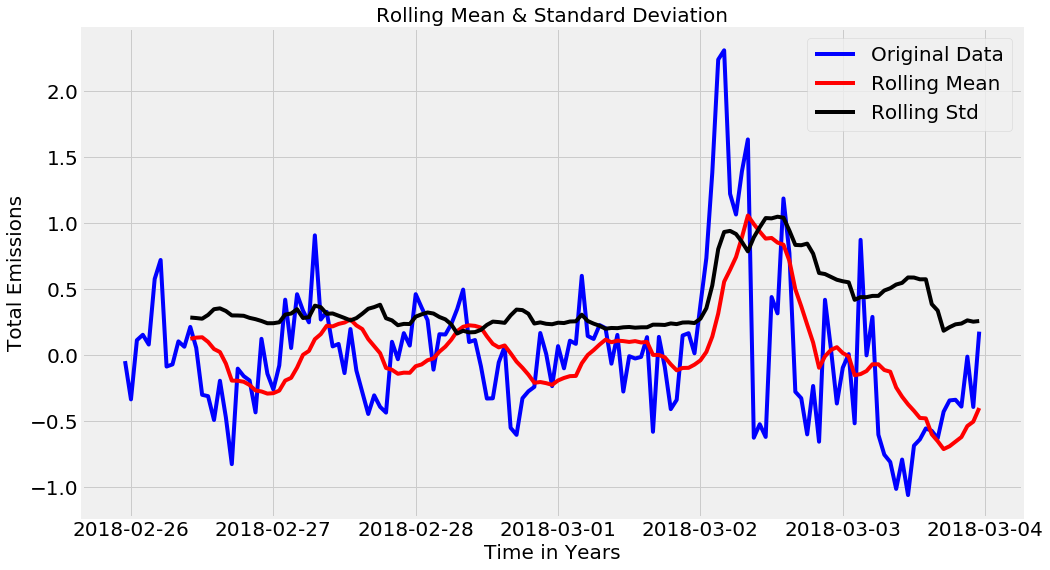

In [219]:
uber_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(uber_moving_avg_diff)

In [226]:
TestStationaryAdfuller(uber_moving_avg_diff)

Test Statistic                  -4.153657
p-value                          0.000789
#Lags Used                       1.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


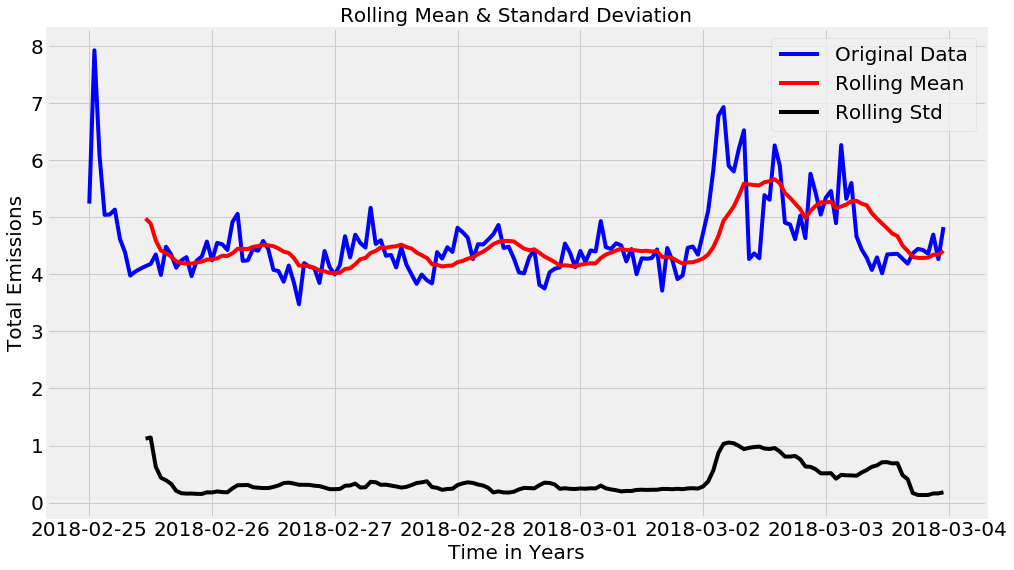

In [220]:
uber_first_difference = y_uber_h - y_uber_h.shift(1)  
TestStationaryPlot(y_uber_h.dropna(inplace=False))

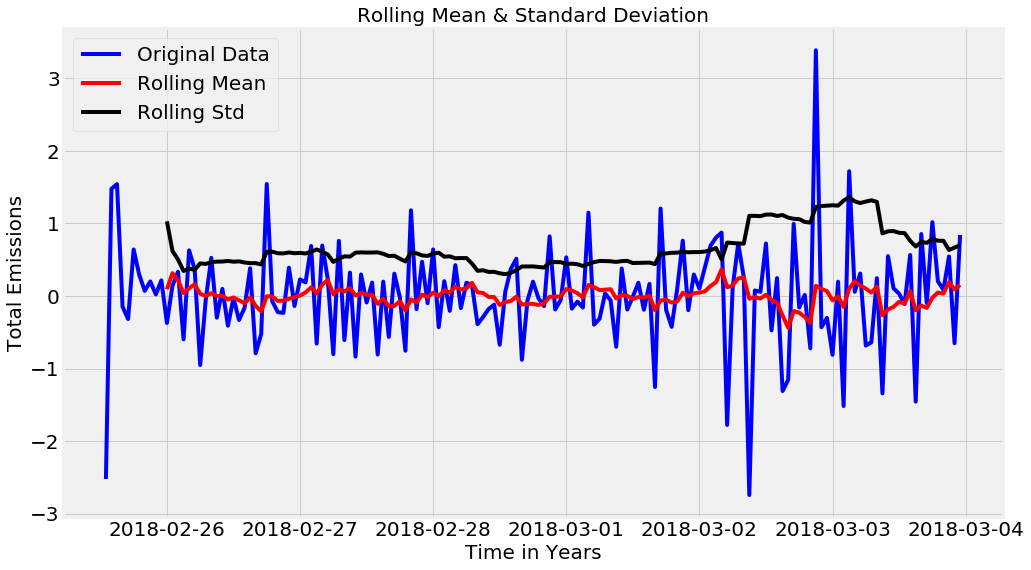

In [221]:
uber_seasonal_first_difference = uber_first_difference - uber_first_difference.shift(12)  
TestStationaryPlot(uber_seasonal_first_difference.dropna(inplace=False))

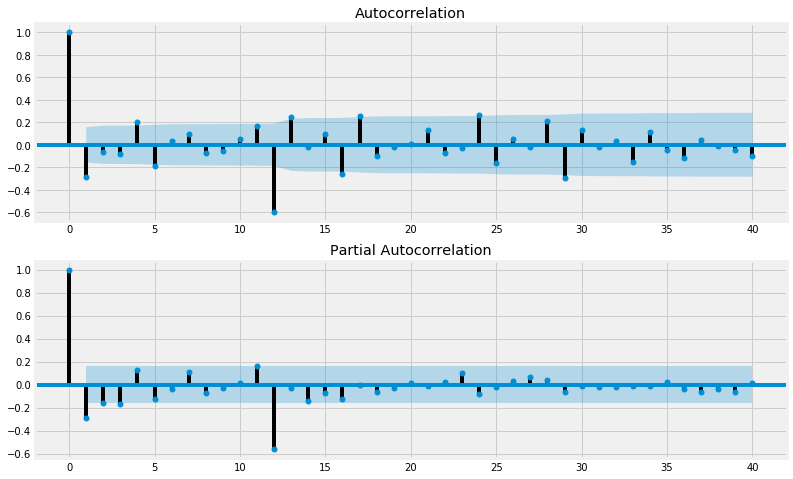

In [222]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(uber_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(uber_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)